# Run this after running `plot_results.ipynb`

In [674]:
from astropy.io import ascii
from astropy.table import Table

In [675]:
charli = Table.read('charli.csv', format='ascii')
charli.rename_column('Star', 'Target')

charli.rename_column('Teff', '$T_\mathrm{eff, MOOG}$')
charli.remove_columns(['N lines Fe I', 'N lines Fe II', 'Trends Plot', 'Notes', 'micro', 'log g', '[Fe I/H]', '[Fe II/H]'])

#charli['[Fe I/H]'] = ["${0}$".format(s.replace('+/-', '\pm')) if hasattr(s, 'replace') else np.nan for s in charli['[Fe I/H]']]
#charli['[Fe II/H]'] = ["${0}$".format(s.replace('+/-', '\pm')) if hasattr(s, 'replace') else np.nan for s in charli['[Fe I/H]']]

In [676]:
charli

Target,"$T_\mathrm{eff, MOOG}$"
str13,int64
51Peg,5500
GJ702B,4385
GJ9781A,4500
HATP11,4790
HD10697,5070
HD110833,5130
HD113827,4510
HD122120,4960
HD127506,4955


In [677]:
# jason = Table.read('/Users/bmmorris/Dropbox/Apps/ShareLaTeX/freckles/jc-notes/Teff-SME.txt', 
#                    comment='#', delimiter=' ', format='ascii.fixed_width_no_header', 
#                    names=['Target', 'N', 'Number', '$T_\mathrm{eff, SME}$', 'T_eff_sme_err', '$\log g$', '$Z$', '$v \sin i$'])
# jason.remove_columns(['N', 'Number', 'T_eff_sme_err'])
# jason['Target'] = [i if i != 'sigDra' else 'sigmaDraconis' for i in jason['Target']]

In [794]:
# jason = Table.read('/Users/bmmorris/Dropbox/Apps/ShareLaTeX/freckles/jc-notes/Teff-SME-p.txt', 
#                    comment='#', delimiter=' ', format='ascii.fixed_width_no_header', 
#                    names=['Target', 'N', 'Number', '$T_\mathrm{eff, SME}$', 'XX', 'T_eff_sme_err', '$\log g$', '$Z$', '$v \sin i$'])
# jason.remove_columns(['N', 'Number', 'T_eff_sme_err'])
# jason['Target'] = [i if i != 'sigDra' else 'sigmaDraconis' for i in jason['Target']]

rows = []
f = open('/Users/bmmorris/Dropbox/Apps/ShareLaTeX/freckles/jc-notes/Teff-SME-p.txt').read().splitlines()

for line in f: 
    if not line.startswith('#'):
        if len(line.split()) == 9:
            star, n0, n1, teff, std, tefferr, logg, z, vsini = line.split()
            row = [star if star != 'sigDra' else 'sigmaDraconis', 
                   "${0:.0f} \pm {1:.0f}$".format(float(teff), float(tefferr)), logg, z, vsini]
            rows.append(row)
            
jason = Table(rows=rows, names=['Target', '$T_\mathrm{eff, SME}$','$\log g$', '$Z$', '$v \sin i$'])

In [795]:
from json import load

star_key = load(open('stars.json'))

spot_stars = Table(rows=[[star, star_key[star][1][0]] for star in star_key], names=['Target', 'Spot'])

In [796]:
data_start = 3
gaia = ascii.read('temperatures/gaia2.tsv', #names='Target,Gmag,Teff_Gaia,Teff_Gaia_lower,Teff_Gaia_upper'.split(','), 
                  data_start=data_start, delimiter='\t')
# spocs2005 = ascii.read('temperatures/spocs2005_temps.tsv', names='Target, Teff_spocs2005'.split(', '), 
#                        data_start=data_start, delimiter='\t')
# spocs2016 = ascii.read('temperatures/spocs2016_temps.tsv', names='Target, Teff_spocs2016'.split(', '), 
#                        data_start=data_start, delimiter='\t')

In [797]:
gb = gaia.group_by('_1')

In [798]:
from astropy.table import vstack
import numpy as np

gaia_dedup = Table(gb.groups[0])

for i in np.arange(1, len(gb.groups)): 
    group = gb.groups[i]
    gaia_dedup.add_row(group[np.argmin(group['Gmag'])])
    #gaia_dedeup = vstack([gaia_dedup, group[np.argmin(group['Gmag'])]], join_type='inner')

In [799]:
# %matplotlib inline
# import matplotlib.pyplot as plt
np.median(np.sqrt(gaia_dedup['e_BPmag']**2 + gaia_dedup['e_RPmag']**2))

0.0032202484376209236

In [800]:
remove_cols = ['_r', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 
               'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', 'FG', 'e_FG', 'Gmag', 'e_Gmag', 'FBP', 
               'e_FBP', 'BPmag', 'e_BPmag', 'FRP', 'e_FRP', 'RPmag', 'e_RPmag', 'RV',  # 'BP-RP', 
               'e_RV', 'AG', 'E(BP-RP)', 'Rad', 'Lum', 'DR2Name', 'SolID', 'RandomI', 'Epoch', 
               'RPlx', 'RADEcor', 'RAPlxcor', 'RApmRAcor', 'RApmDEcor', 'DEPlxcor', 'DEpmRAcor', 
               'DEpmDEcor', 'PlxpmRAcor', 'PlxpmDEcor', 'pmRApmDEcor', 'NAL', 'NAC', 'NgAL', 
               'NbAL', 'gofAL', 'chi2AL', 'epsi', 'sepsi', 'Solved', 'APF', 'WAL', 'pscol', 
               'e_pscol', 'fvarpi', 'MatchObsA', 'Nper', 'amax', 'type', 'MatchObs', 'o_Gmag', 
               'RFG', 'o_BPmag', 'RFBP', 'o_RPmag', 'RFRP', 'E(BR/RP)', 'Mode', 'BP-G', 'G-RP', 
               'o_RV', 'Tefftemp', 'loggtemp', '[Fe/H]temp', 'Var', 'GLON', 'GLAT', 'ELON', 'ELAT', 
               'fPriam', 'b_AG', 'B_AG', 'b_E(BP-RP)', 'B_E(BP-RP)', 'fFLAME', 'b_Rad', 'B_Rad', 
               'b_Lum', 'B_Lum', 'RAJ2000', 'e_RAJ2000', 'DEJ2000', 'e_DEJ2000']
# 'Teff', 'b_Teff', 'B_Teff', 

gaia_dedup.remove_columns(remove_cols)

In [801]:
gaia_dedup.rename_column('_1', 'Target')

In [802]:
gaia_dedup.rename_column('b_Teff', 'Teff_Gaia_lower')
gaia_dedup.rename_column('B_Teff', 'Teff_Gaia_upper')
gaia_dedup.rename_column('Teff', 'Teff_Gaia')

In [803]:
import numpy as np
gaia_teffs = [gaia_dedup['Teff_Gaia'], 
              gaia_dedup['Teff_Gaia']-gaia_dedup['Teff_Gaia_lower'], 
              gaia_dedup['Teff_Gaia_upper']-gaia_dedup['Teff_Gaia']]

gaia_formatted = []
for mid, lower, upper in Table(gaia_teffs, names=['Mid', 'Lower', 'Upper']):
    if isinstance(mid, float):
        gaia_formatted.append('${0:.0f}^{{+{1:.0f}}}_{{-{2:.0f}}}$'.format(mid, upper, lower))
    else: 
        gaia_formatted.append('')

In [804]:
from astropy.table import Column, join
gaia_dedup.remove_columns(['Teff_Gaia', 'Teff_Gaia_lower', 'Teff_Gaia_upper'])
gaia_dedup.add_column(Column(gaia_formatted, '$T_\mathrm{eff,Gaia}$'))
gaia_dedup['Target'] = [s.strip().replace(' ', '').replace('-', '') for s in list(gaia_dedup['Target'])]

In [805]:
gaia_spot = join(gaia_dedup, spot_stars, join_type='outer')

gaia_spot.add_index('Target')

spot_temps = []
for s in gaia_spot['Spot']:
    if isinstance(s, str) and s in gaia_spot['Target']:
        spot_temps.append(gaia_spot.loc[s]['$T_\mathrm{eff,Gaia}$'])
    else: 
        spot_temps.append("")
        
gaia_spot.add_column(Column(spot_temps, '$T_S$'))
gaia_spot.remove_column('Spot')

In [806]:
gaia_spot = join(gaia_spot, jason, keys='Target', join_type='outer')

gaia_spot = join(gaia_spot, charli, keys='Target', join_type='outer')

In [807]:
gaia_spot.colnames

['Target',
 'BP-RP',
 '$T_\\mathrm{eff,Gaia}$',
 '$T_S$',
 '$T_\\mathrm{eff, SME}$',
 '$\\log g$',
 '$Z$',
 '$v \\sin i$',
 '$T_\\mathrm{eff, MOOG}$']

In [808]:
col_order = ['Target', 'BP-RP', '$T_\\mathrm{eff,Gaia}$', '$T_\\mathrm{eff, SME}$', '$T_\\mathrm{eff, MOOG}$', '$\\log g$', '$Z$', '$v \\sin i$', '$T_S$']
gaia_spot = gaia_spot[col_order]

In [809]:
# import sys
# gaia_spot.write(sys.stdout, format='latex')

In [810]:
sinds = Table.read('/Users/bmmorris/git/arces_hk/freckles.tex')
sinds.sort('Target')

In [811]:
sinds['Target'] = [s.strip().replace(' ', '').replace('-', '') for s in sinds['Target']]

In [812]:
sinds.pprint(max_lines=1000)

    Target      Sp. Type         $S$       $\log R^\prime_\mathrm{HK}$ Active? 
------------- ------------ --------------- --------------------------- --------
        51Peg         G2IV $0.15 \pm 0.01$            $-4.90 \pm 0.05$ Inactive
        EKDra        G1.5V $0.58 \pm 0.02$            $-3.91 \pm 0.02$   Active
        EQVir         K5Ve $3.00 \pm 0.12$            $-3.65 \pm 0.02$   Active
       GJ4099       M2.0Ve $0.87 \pm 0.05$            $-4.67 \pm 0.02$ Inactive
       GJ702B          K4V $0.84 \pm 0.04$            $-3.61 \pm 0.02$   Active
        GJ705           K2 $0.12 \pm 0.01$            $-5.44 \pm 0.04$ Inactive
      GJ9781A           K7 $0.99 \pm 0.04$            $-4.46 \pm 0.02$   Active
       HATP11          K4V $0.53 \pm 0.02$            $-4.46 \pm 0.02$   Active
      HD10697         G3Va $0.14 \pm 0.01$            $-5.01 \pm 0.06$ Inactive
     HD110833          K3V $0.30 \pm 0.01$            $-4.52 \pm 0.02$ Inactive
     HD113827          K4V $1.03 \pm 0.0

In [813]:
from astropy.table import hstack

temps_sinds = join(gaia_spot, sinds, join_type='outer', keys='Target')

In [814]:
temps_sinds.pprint(max_lines=1000, max_width=1000)

    Target     BP-RP  $T_\mathrm{eff,Gaia}$ $T_\mathrm{eff, SME}$ $T_\mathrm{eff, MOOG}$ $\log g$  $Z$  $v \sin i$        $T_S$           Sp. Type         $S$       $\log R^\prime_\mathrm{HK}$ Active? 
------------- ------- --------------------- --------------------- ---------------------- -------- ----- ---------- -------------------- ------------ --------------- --------------------------- --------
        51Peg   0.817   $5830^{+214}_{-55}$         $5804 \pm 26$                   5500     4.39  0.24        1.1 $3846^{+181}_{-190}$         G2IV $0.15 \pm 0.01$            $-4.90 \pm 0.05$ Inactive
        EKDra   0.875  $5584^{+115}_{-193}$                    --                     --       --    --         --   $5253^{+61}_{-89}$        G1.5V $0.58 \pm 0.02$            $-3.91 \pm 0.02$   Active
EPIC211928486  1.4171  $4682^{+149}_{-250}$                    --                     --       --    --         -- $4182^{+260}_{-132}$           --              --                          --

In [815]:
temps_sinds.sort('$\log R^\prime_\mathrm{HK}$')
temps_sinds.remove_column('Active?')

In [816]:
# names = list(star_key.keys())
# comp_stars = Table([names, ["{0}, {1}".format(star_key[star][0][0], star_key[star][1][0]) for star in names]], names=['Target', 'Comp.'])

In [817]:
fs_table = Table.read('f_S.tex')
fs_table['Target'] = [t.strip().replace(' ', '').replace('-', '') for t in fs_table['Target']]

In [818]:
full_table = join(temps_sinds, fs_table, join_type='outer', keys='Target')
full_table.sort('$\log R^\prime_\mathrm{HK}$')

In [819]:
col_order = ['Target', 'Sp. Type', 'BP-RP', '$T_\\mathrm{eff,Gaia}$', '$T_\\mathrm{eff, SME}$', '$T_\\mathrm{eff, MOOG}$', '$\\log g$', '$Z$', '$v \\sin i$',
             '$S$', '$\\log R^\\prime_\\mathrm{HK}$', '$f_S$'] # '$T_S$', 
full_table = full_table[col_order]

In [820]:
full_table.add_index('Target')

# Remove SB 2
# row = full_table.loc['HD45088']
# full_table.remove_row(row.index)

for star in ['EPIC211928486', 'EPIC211966629', 'KIC9652680']:
    row = full_table.loc[star]
    full_table.remove_row(row.index)

In [821]:
# full_table.remove_row(-1)
# full_table.write('megatable.tex', format='aastex', caption="\label{tab:megatable}", latexdict = {'tabletype': 'deluxetable*'})
full_table.write('/Users/bmmorris/Dropbox/Apps/ShareLaTeX/freckles/megatable.tex', format='aastex', 
                 caption="\label{tab:megatable}", latexdict = {'tabletype': 'deluxetable*', 
                                                               'col_align': 'lcc|ccc|ccc|cc|cc'}, 
                 overwrite=True)

In [822]:
full_table.pprint(max_lines=1000)

    Target      Sp. Type   ... $\log R^\prime_\mathrm{HK}$      $f_S$     
------------- ------------ ... --------------------------- ---------------
     HD151288       K7.5Ve ...            $-3.58 \pm 0.02$ $0.28 \pm 0.06$
       GJ702B          K4V ...            $-3.61 \pm 0.02$ $0.45 \pm 0.06$
        EQVir         K5Ve ...            $-3.65 \pm 0.02$              --
     HD175742          K0V ...            $-3.78 \pm 0.02$ $0.54 \pm 0.13$
     HD129333        G1.5V ...            $-3.86 \pm 0.02$              --
        EKDra        G1.5V ...            $-3.91 \pm 0.02$              --
      HD45088         K2Ve ...            $-3.98 \pm 0.02$ $0.52 \pm 0.14$
     HD113827          K4V ...            $-4.00 \pm 0.02$ $0.15 \pm 0.06$
     HD134319         G5V: ...            $-4.12 \pm 0.02$ $0.41 \pm 0.06$
     HD127506        K3.5V ...            $-4.13 \pm 0.02$ $0.47 \pm 0.15$
     HD200560        K2.5V ...            $-4.17 \pm 0.02$ $0.01 \pm 0.06$
      HD88230     K6VeFe-

In [823]:
!cat /Users/bmmorris/Dropbox/Apps/ShareLaTeX/freckles/megatable.tex

\begin{deluxetable*}{lcc|ccc|ccc|cc|cc}
\tablecaption{\label{tab:megatable}}
\tablehead{\colhead{Target} & \colhead{Sp. Type} & \colhead{BP-RP} & \colhead{$T_\mathrm{eff,Gaia}$} & \colhead{$T_\mathrm{eff, SME}$} & \colhead{$T_\mathrm{eff, MOOG}$} & \colhead{$\log g$} & \colhead{$Z$} & \colhead{$v \sin i$} & \colhead{$S$} & \colhead{$\log R^\prime_\mathrm{HK}$} & \colhead{$f_S$}}
\startdata
HD151288 & K7.5Ve & 1.7053 & $4224^{+300}_{-270}$ & $4217 \pm 58$ & 4395 & 5.25 & -0.14 & 1.1 & $1.27 \pm 0.05$ & $-3.58 \pm 0.02$ & $0.28 \pm 0.06$ \\
GJ702B & K4V & 1.0 & $5305^{+341}_{-245}$ & $4483 \pm 43$ & 4385 & 4.85 & -0.15 & 0.7 & $0.84 \pm 0.04$ & $-3.61 \pm 0.02$ & $0.45 \pm 0.06$ \\
EQVir & K5Ve & 1.496 & $4433^{+82}_{-106}$ & $4519 \pm 90$ &  & 4.82 & -0.18 & 9.6 & $3.00 \pm 0.12$ & $-3.65 \pm 0.02$ &  \\
HD175742 & K0V & 1.213 & $4874^{+43}_{-74}$ & $4980 \pm 36$ & 4930 & 4.40 & -0.09 & 14.7 & $1.26 \pm 0.05$ & $-3.78 \pm 0.02$ & $0.54 \pm 0.13$ \\
HD129333 & G1.5V & 0.875 & $5584^{+115

In [824]:
from astropy.table import Row

rows = []
counter = -1
for star in full_table['Target']:
    if star == 'HD129333': 
        pass
       # star = 'sigmaDraconis'
    
    if (not star in ['KIC9652680'] and star in star_key) or star in ['HATP11']:
        counter += 1 
        if not star == 'HATP11':
            target_temp = full_table.loc[star]['$T_\mathrm{eff,Gaia}$']
            comp1_name = star_key[star][0][0]
            comp1_temp = full_table.loc[comp1_name]['$T_\mathrm{eff,Gaia}$']
            comp2_name = star_key[star][1][0]
            comp2_temp = full_table.loc[comp2_name]['$T_\mathrm{eff,Gaia}$']
        else: 
            target_temp = full_table.loc[star]['$T_\mathrm{eff,Gaia}$']
            comp1_name = "HD5857"
            comp1_temp = full_table.loc[comp1_name]['$T_\mathrm{eff,Gaia}$']
            comp2_name = "GJ705"
            comp2_temp = full_table.loc[comp2_name]['$T_\mathrm{eff,Gaia}$']
            

        delta_t = float(comp1_temp.split('^')[0][1:]) - float(comp2_temp.split('^')[0][1:])
        
        rows.append([star, target_temp, comp1_name, comp1_temp, comp2_name, comp2_temp, int(delta_t)])

comparison_table = Table(rows=rows, names=['Target', '$T_\mathrm{eff, Gaia}$', 'Comp. 1', 
                                           '$T_\mathrm{Q}$', 'Comp. 2', '$T_\mathrm{S}$', '$\Delta T$'])

In [825]:
comparison_table.sort('$T_\mathrm{eff, Gaia}$')

In [826]:
comparison_table.write('/Users/bmmorris/Dropbox/Apps/ShareLaTeX/freckles/comp_table.tex', format='aastex', 
                         caption="\label{tab:comptable}", latexdict = {'tabletype': 'deluxetable*', 
                                                                       'col_align': 'lc|cc|cc|c'}, 
                         overwrite=True)

In [827]:
comparison_table.pprint(max_lines=100)

    Target    $T_\mathrm{eff, Gaia}$ ...    $T_\mathrm{S}$    $\Delta T$
------------- ---------------------- ... -------------------- ----------
     HD151288   $4224^{+300}_{-270}$ ...  $3882^{+163}_{-82}$        583
        EQVir    $4433^{+82}_{-106}$ ... $3846^{+181}_{-190}$        668
     HD148467   $4474^{+153}_{-201}$ ... $3846^{+181}_{-190}$        619
      GJ9781A    $4484^{+95}_{-110}$ ... $3846^{+181}_{-190}$        619
     HD113827   $4610^{+459}_{-191}$ ... $3846^{+181}_{-190}$        619
      HD47752     $4700^{+69}_{-22}$ ...  $4465^{+102}_{-66}$        386
     HD127506     $4711^{+55}_{-83}$ ...  $4465^{+102}_{-66}$        386
      HD82106     $4749^{+71}_{-40}$ ...  $4465^{+102}_{-66}$        386
       HATP11   $4757^{+154}_{-111}$ ...  $4465^{+102}_{-66}$        247
      HD45088     $4786^{+39}_{-36}$ ...  $4465^{+102}_{-66}$        386
      HD79555   $4861^{+149}_{-251}$ ...  $4465^{+102}_{-66}$        386
     HD175742     $4874^{+43}_{-74}$ ...  $4465^{+1

In [828]:
# fig, ax = plt.subplots(2, 1, figsize=(4, 8))
# ax[0].scatter([floatify(s) for s in full_table['$T_\mathrm{eff,Gaia}$']], 
#            full_table['$T_\mathrm{eff, SME}$'].data, color='k')
# ax[0].set(xlim=[3800, 6200], ylim=[3800, 6200])
# fontsize=14
# ax[0].set_xlabel('$T_\mathrm{eff, Gaia}$', fontsize=fontsize)
# ax[0].set_ylabel('$T_\mathrm{eff, SME}$', fontsize=fontsize)

# ax[1].set_xlabel('$T_\mathrm{eff, Gaia}$', fontsize=fontsize)
# ax[1].set_ylabel('$T_\mathrm{eff, MOOG}$', fontsize=fontsize)

# for axis in ax:
#     for s in ['right', 'top']:
#         axis.spines[s].set_visible(False)
#     axis.grid(ls=':')
#     axis.plot([4000, 6000], [4000, 6000], ls='--', color='k')

# fig.savefig('paper_plots/temperature_comparison.pdf', bbox_inches='tight')

In [829]:
# gaia_dedup.add_index('Target')

# teffs = [float(s.split('^')[0][1:]) for s in full_table['$T_\mathrm{eff,Gaia}$']]
# colors = [gaia_dedup.loc[t]['BP-RP'] for t in full_table['Target']]

In [830]:
# plt.scatter(teffs, colors)
# plt.xlim([3700, 6400])
# plt.ylim([0.5, 2.5])
# plt.xlabel('$T_\mathrm{eff}$')
# plt.ylabel('BP-RP')

In [831]:
# fs = [float(s.split('\pm')[0][1:]) if isinstance(s, str) else 0 for s in full_table['$f_S$']]
# vsini = [float(s) if (isinstance(s, str) and not s == '****') else 0 for s in full_table['$v \sin i$']]

# plt.scatter(vsini, fs)

In [832]:
# comparison_table['Comp. 1'], comparison_table['Comp. 2']

gaia_dedup.add_index('Target')

In [833]:
colors_comp1 = [gaia_dedup.loc[t]['BP-RP'] for t in comparison_table['Comp. 1']]
colors_comp2 = [gaia_dedup.loc[t]['BP-RP'] for t in comparison_table['Comp. 2']]
colors_targets = [gaia_dedup.loc[t]['BP-RP'] for t in comparison_table['Target']]

Text(0,0.5,'Comparison BP-RP')

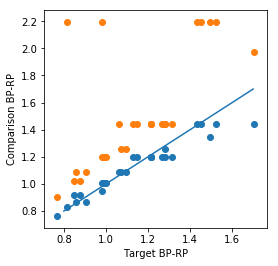

In [834]:
plt.figure(figsize=(4, 4))
plt.scatter(colors_targets, colors_comp1, color='C0')
plt.scatter(colors_targets, colors_comp2, color='C1')
plt.plot([0.8, 1.7], [0.8, 1.7])
plt.xlabel('Target BP-RP')
plt.ylabel('Comparison BP-RP')

In [835]:
gaia_dedup.sort('BP-RP')

In [836]:
rotation_table = Table.read('rotation_periods.txt', names=['Target', '$P_\mathrm{rot}$ [d]', 'Reference'], delimiter=' ', format='ascii')

In [837]:
rotation_table.sort('$P_\mathrm{rot}$ [d]')
rotation_table.write('/Users/bmmorris/Dropbox/Apps/ShareLaTeX/freckles/rotation_periods.tex', format='aastex', 
                     latexdict={'col_align': 'lcr', 'tabletype': 'deluxetable*'}, 
                     caption="Literature rotation periods. \label{tab:rotation}", overwrite=True)